In [ ]:
import numpy as np
import pandas as pd


#device = 'cuda' if cuda.is_available() else 'cpu'
#print(device)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data = pd.read_csv('/content/drive/MyDrive/datasets/split/train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/datasets/split/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/datasets/split/test.csv')

train = train_data

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    print(label)
    print(train[label].value_counts().to_string())

toxic
0    115434
1     12223
severe_toxic
0    126396
1      1261
obscene
0    120908
1      6749
threat
0    127279
1       378
insult
0    121391
1      6266
identity_hate
0    126544
1      1113


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from keras.preprocessing import sequence
from keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.corpus import words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_data(df):
  df["comment_text"] = df["comment_text"].str.lower()
  df["comment_text"] = df["comment_text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")

In [ ]:
#Data Cleaning
clean_data(train_data)
clean_data(valid_data)
clean_data(test_data)

In [ ]:
#bigX = train.drop(labels,axis=1).to_numpy().reshape(-1,)
#bigy = train[labels].to_numpy()

bigX = train_data['comment_text'].to_numpy().reshape(-1,)
bigy = train_data[labels].to_numpy()
print('bigX shape:', bigX.shape)
print('bigy shape:', bigy.shape)
print(bigy)

bigX shape: (127657,)
bigy shape: (127657, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [ ]:
'''from sklearn.model_selection import train_test_split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(bigX, bigy,
                                                    test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_dev, y_train_dev,
                                                    test_size=0.2)
'''
X_train = train_data['comment_text'].to_numpy().reshape(-1,)
y_train = train_data[labels].to_numpy()
X_val = valid_data['comment_text'].to_numpy().reshape(-1,)
y_val = valid_data[labels].to_numpy()
X_test = test_data['comment_text'].to_numpy().reshape(-1,)
y_test = test_data[labels].to_numpy()

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(bigX)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix_train = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_test)
sequences_matrix_test = pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(X_val)
sequences_matrix_val = pad_sequences(sequences,maxlen=max_len)
# sequences = tok.texts_to_sequences(bigX)
# sequences_matrix_big = pad_sequences(sequences,maxlen=max_len)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
# should the output shape be 768 like BERT had?
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.GRU(4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid')) # this activation function is different form BERT, which is using linear

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 gru (GRU)                   (None, 4)                 672       
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 53,494
Trainable params: 53,494
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])'''
LEARNING_RATE = 1e-05
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=1,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))

250/250 [==============================] - 52s 195ms/step - loss: 0.6898 - accuracy: 0.5760 - val_loss: 0.6861 - val_accuracy: 0.7124


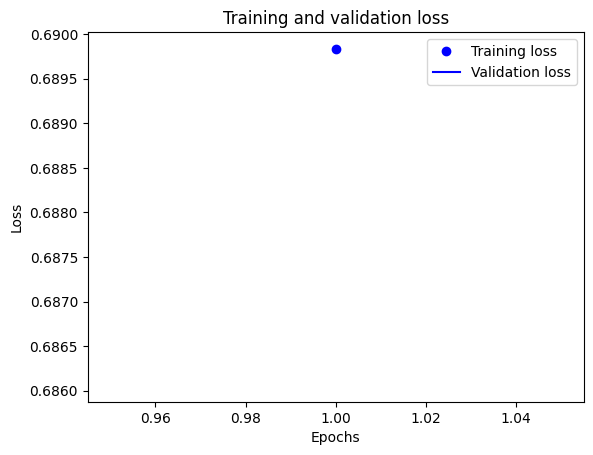

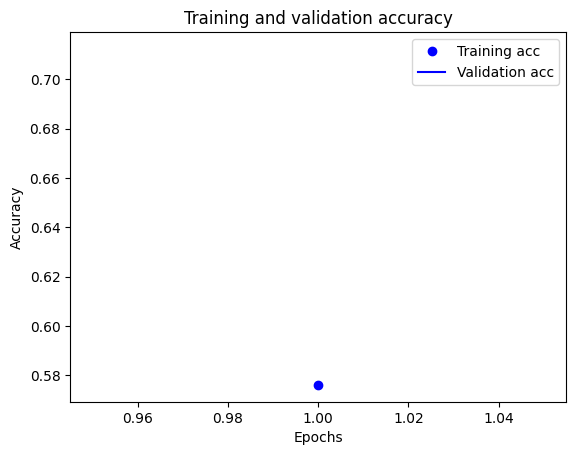

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(sequences_matrix_test, y_test)

2000/2000 [==============================] - 37s 18ms/step - loss: 0.6861 - accuracy: 0.7189


Epoch 1/5
250/250 [==============================] - 47s 188ms/step - loss: 0.6807 - accuracy: 0.8846 - val_loss: 0.6744 - val_accuracy: 0.9820
Epoch 2/5
250/250 [==============================] - 46s 185ms/step - loss: 0.6661 - accuracy: 0.9922 - val_loss: 0.6567 - val_accuracy: 0.9934
Epoch 3/5
250/250 [==============================] - 48s 192ms/step - loss: 0.6451 - accuracy: 0.9943 - val_loss: 0.6323 - val_accuracy: 0.9935
Epoch 4/5
250/250 [==============================] - 49s 197ms/step - loss: 0.6172 - accuracy: 0.9943 - val_loss: 0.6010 - val_accuracy: 0.9935
Epoch 5/5
250/250 [==============================] - 47s 188ms/step - loss: 0.5825 - accuracy: 0.9943 - val_loss: 0.5632 - val_accuracy: 0.9935


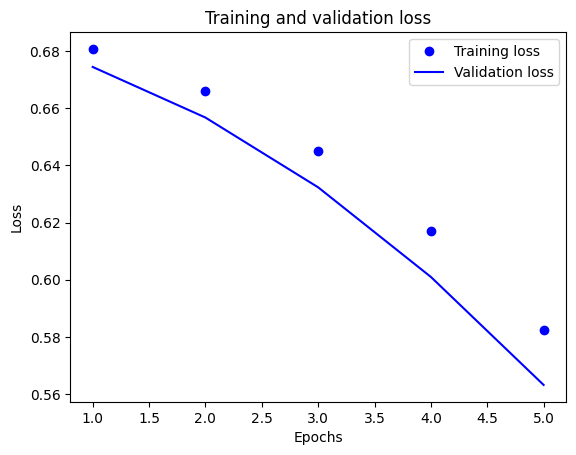

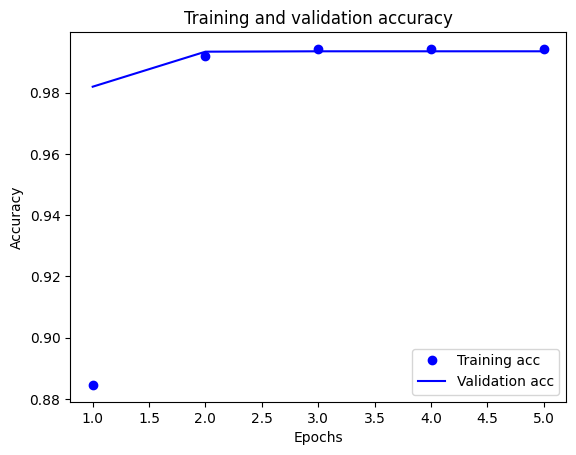

2000/2000 [==============================] - 35s 18ms/step - loss: 0.5631 - accuracy: 0.9976


[0.5630738139152527, 0.9976085424423218]

In [ ]:
'''model = models.Sequential()
model.add(layers.Embedding(max_words,50,input_length=max_len, input_shape=[max_len]))
model.add(layers.GRU(4)) # GRU is used
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])'''

history = model.fit(sequences_matrix_train,
                    y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(sequences_matrix_val, y_val))


acc = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model.evaluate(sequences_matrix_test, y_test)

In [ ]:
results = model.evaluate(sequences_matrix_test, y_test)

2000/2000 [==============================] - 34s 17ms/step - loss: 0.5631 - accuracy: 0.9976


In [ ]:
from sklearn import metrics

valid_outputs = model.predict(sequences_matrix_val)
valid_final_outputs_for_accuracy = np.where(valid_outputs < 0.5, 0.0, 1.0)
print('validation output raw')
print(valid_outputs.shape)
print(valid_outputs)
print()
print('validation accuracy labels:', valid_final_outputs_for_accuracy)
print()

test_outputs = model.predict(sequences_matrix_test)
test_final_outputs_for_accuracy = np.where(test_outputs < 0.5, 0.0, 1.0)
print('test output raw')
print(test_outputs.shape)
print(test_outputs)
print()
print('test accuracy labels:', test_final_outputs_for_accuracy)
print()

print('Validation accuracy:', metrics.accuracy_score(y_val, valid_final_outputs_for_accuracy))
print('Test accuracy:', metrics.accuracy_score(y_test, test_final_outputs_for_accuracy))

998/998 [==============================] - 19s 19ms/step
validation output raw
(31914, 6)
[[0.45723805 0.43742    0.43816105 0.41321632 0.4269939  0.42540336]
 [0.44988617 0.43081355 0.42993438 0.39875352 0.41681927 0.41336277]
 [0.44962907 0.43070468 0.42981523 0.3981315  0.41626334 0.4130343 ]
 ...
 [0.4480785  0.42672563 0.4252636  0.3935474  0.41264752 0.40858212]
 [0.44654158 0.42618388 0.42345124 0.3902357  0.4108157  0.40596247]
 [0.4471898  0.42653325 0.4253514  0.39234126 0.411893   0.40768507]]

validation accuracy labels: [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

2000/2000 [==============================] - 33s 16ms/step
test output raw
(63978, 6)
[[0.450192   0.42871997 0.426371   0.39595985 0.41402334 0.41125613]
 [0.44799182 0.42587796 0.42303845 0.39218003 0.41243857 0.4069019 ]
 [0.44764915 0.42718744 0.42550623 0.39245287 0.4117533  0.40833843]
 ...
 [0.44801733 0.42479992 0.4206

In [ ]:
print('number of positive labels in validation guess:', np.count_nonzero(valid_final_outputs_for_accuracy))
print('number of positive labels in test guess:', np.count_nonzero(test_final_outputs_for_accuracy))

number of positive labels in validation guess: 0
number of positive labels in test guess: 0
